In [ ]:
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt

# Loading of fibresimulator

fs_path = "fibers_volume_radius.nii"  # <--- change if needed (file source)
'''
Sudip, make sure the fibre volume is at the same folder with your code.
'''

nii = nib.load(fs_path)
vol = nii.get_fdata().astype(np.float32)  # (Nz0, Ny0, Nx0) = (z, y, x)
Nz0, Ny0, Nx0 = vol.shape
print("Original FS volume:", vol.shape)

# 1) Downsample in original orientation
vol_ds0 = vol[::2, ::4, ::4]   # (Z', Y', X')
print("Downsampled (original axes):", vol_ds0.shape)

vol_ds = np.transpose(vol_ds0, (2, 1, 0))
Nz, Ny, Nx = vol_ds.shape
print("Reoriented volume (sideways scan):", vol_ds.shape)

vol_ds -= vol_ds.min()
if vol_ds.max() > 0:
    vol_ds /= vol_ds.max()

# --- Define physical FOV: 800 x 800 mm in x–y ---
Sy = 800.0  # mm (y direction)
Sx = 800.0  # mm (x direction)

# Choose isotropic voxel size in x,y and same for z (for simplicity)
dy = Sy / Ny
dx = Sx / Nx
dz = dy              # isotropic voxels
Sz = Nz * dz

# bounding box
zmin, zmax = -Sz/2, Sz/2
ymin, ymax = -Sy/2, Sy/2   # -400..+400
xmin, xmax = -Sx/2, Sx/2

print(f"World FOV (mm): z=[{zmin:.1f},{zmax:.1f}], y=[{ymin:.1f},{ymax:.1f}], x=[{xmin:.1f},{xmax:.1f}]")

Original FS volume: (800, 800, 800)
Downsampled (original axes): (400, 200, 200)
Reoriented volume (sideways scan): (200, 200, 400)
World FOV (mm): z=[-400.0,400.0], y=[-400.0,400.0], x=[-400.0,400.0]


In [ ]:
# 13x13 grid

ROWS, COLS = 128, 128       # detector resolution
SDD = 600.0                 # source–detector distance in mm
src_z = +SDD / 2.0
det_z = -SDD / 2.0

# Detector physical size: slightly larger than object
DET_H = Sy * 1.05           # mm
DET_W = Sx * 1.05           # mm
px_v = DET_H / ROWS
px_u = DET_W / COLS

# Central detector pixel position & basis vectors
DP0 = np.array([det_z, 0.0, 0.0], dtype=np.float64)
det_v = np.array([0.0, px_v, 0.0], dtype=np.float64)   # rows -> y
det_u = np.array([0.0, 0.0, px_u], dtype=np.float64)   # cols -> x

step = Sy / 12.0   
coords_1d = (np.arange(13) - 6) * step

src_pos = []
for ry in range(13):
    for cx in range(13):
        sy = coords_1d[ry]
        sx = coords_1d[cx]
        src_pos.append(np.array([src_z, sy, sx], dtype=np.float64))
src_pos = np.stack(src_pos, axis=0)
V = src_pos.shape[0]
print("num views (13x13):", V)

# Precompute detector pixel positions (world coords)
rr, cc = np.meshgrid(np.arange(ROWS), np.arange(COLS), indexing='ij')
r0 = (ROWS - 1) / 2.0
c0 = (COLS - 1) / 2.0
rv = (rr - r0).astype(np.float64)
cu = (cc - c0).astype(np.float64)
P0 = DP0[None,None,:] + rv[...,None]*det_v[None,None,:] + cu[...,None]*det_u[None,None,:]  # (ROWS, COLS, 3)



num views (13x13): 169


In [ ]:
# Helper (still the same from the old code!)

def world_to_index(z_w, y_w, x_w):
    iz = (z_w - zmin) / (zmax - zmin) * (Nz - 1)
    iy = (y_w - ymin) / (ymax - ymin) * (Ny - 1)
    ix = (x_w - xmin) / (xmax - xmin) * (Nx - 1)
    return iz, iy, ix

def sample_trilinear(vol, z_w, y_w, x_w):
    iz, iy, ix = world_to_index(z_w, y_w, x_w)

    iz0 = np.floor(iz).astype(int); iz1 = iz0 + 1
    iy0 = np.floor(iy).astype(int); iy1 = iy0 + 1
    ix0 = np.floor(ix).astype(int); ix1 = ix0 + 1

    wz = iz - iz0
    wy = iy - iy0
    wx = ix - ix0

    # mask inside volume
    m = ((iz0 >= 0) & (iz1 < Nz) &
         (iy0 >= 0) & (iy1 < Ny) &
         (ix0 >= 0) & (ix1 < Nx))
    if not np.any(m):
        return np.zeros_like(iz, dtype=np.float32)

    val = np.zeros_like(iz, dtype=np.float32)

    # helper
    def get(z, y, x):
        return vol[z, y, x]

    z0, z1 = iz0[m], iz1[m]
    y0, y1 = iy0[m], iy1[m]
    x0, x1 = ix0[m], ix1[m]
    wz0, wz1 = 1 - wz[m], wz[m]
    wy0, wy1 = 1 - wy[m], wy[m]
    wx0, wx1 = 1 - wx[m], wx[m]

    c000 = get(z0, y0, x0)
    c001 = get(z0, y0, x1)
    c010 = get(z0, y1, x0)
    c011 = get(z0, y1, x1)
    c100 = get(z1, y0, x0)
    c101 = get(z1, y0, x1)
    c110 = get(z1, y1, x0)
    c111 = get(z1, y1, x1)

    v = (
        c000 * wz0*wy0*wx0 +
        c001 * wz0*wy0*wx1 +
        c010 * wz0*wy1*wx0 +
        c011 * wz0*wy1*wx1 +
        c100 * wz1*wy0*wx0 +
        c101 * wz1*wy0*wx1 +
        c110 * wz1*wy1*wx0 +
        c111 * wz1*wy1*wx1
    )

    val[m] = v.astype(np.float32)
    return val



In [ ]:
# helper functions (still the same with old code)

def simulate_projections(vol):
    """
    Ray-cast projections for all views and detector pixels.
    Geometry matches the meshless setup.
    """
    V = src_pos.shape[0]
    projs = np.zeros((V, ROWS, COLS), dtype=np.float32)

    # t from source (0) to detector (1)
    num_samples = 256   # <<<<<< INCREASED FROM 64
    ts = np.linspace(0.0, 1.0, num_samples, dtype=np.float32)

    for i in range(V):
        S = src_pos[i]  # (3,)
        D = P0 - S[None,None,:]  # (ROWS, COLS, 3)

        z_w = S[0] + ts[:,None,None] * D[...,0]
        y_w = S[1] + ts[:,None,None] * D[...,1]
        x_w = S[2] + ts[:,None,None] * D[...,2]

        zf = z_w.reshape(-1)
        yf = y_w.reshape(-1)
        xf = x_w.reshape(-1)

        vals = sample_trilinear(vol, zf, yf, xf)
        vals = vals.reshape(num_samples, ROWS, COLS)

        proj = np.sum(vals, axis=0) / num_samples
        projs[i] = proj.astype(np.float32)

        if (i+1) % 20 == 0 or i == 0:
            print(f"  simulated view {i+1}/{V}")

    return projs


print("Simulating projections...")
projs_v_first = simulate_projections(vol_ds)
print("projs_v_first shape:", projs_v_first.shape)



Simulating projections...
  simulated view 1/169
  simulated view 20/169
  simulated view 40/169
  simulated view 60/169
  simulated view 80/169
  simulated view 100/169
  simulated view 120/169
  simulated view 140/169
  simulated view 160/169
projs_v_first shape: (169, 128, 128)


Reconstructing middle slice index 100 z= 2.0
slice_mid shape: (200, 400)


/tmp/ipykernel_928718/3047762408.py:86: RuntimeWarning: overflow encountered in exp
  cutoff = 1.0 / (1.0 + np.exp((K**2 - kmax**2) / 5e-3))


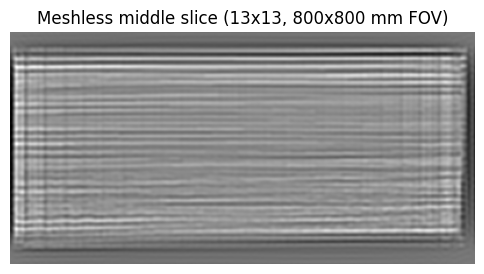

In [ ]:
# Recreating middle slice

def world_to_index_xy_vec(y_w, x_w):
    iy = (y_w - ymin) / (ymax - ymin) * (Ny - 1)
    ix = (x_w - xmin) / (xmax - xmin) * (Nx - 1)
    return iy, ix

def z_of_index_center(k):
    dz_tot = zmax - zmin
    dz_vox = dz_tot / Nz
    return zmin + (k + 0.5) * dz_vox

def map_view_to_zslice(proj, i, z_world):
    proj = proj.astype(np.float32)
    S  = src_pos[i]
    DP = DP0
    DV = det_v
    DU = det_u

    P = DP[None,None,:] + rv[...,None]*DV[None,None,:] + cu[...,None]*DU[None,None,:]  # (ROWS,COLS,3)

    denom = P[...,0] - S[0]
    valid = np.abs(denom) > 1e-12
    t = np.empty_like(denom)
    t[valid] = (z_world - S[0]) / denom[valid]
    valid &= (t > 0.0)
    if not np.any(valid):
        return np.zeros((Ny, Nx), dtype=np.float32)

    Sbc = S[None,None,:]
    R = Sbc + t[...,None]*(P - Sbc)
    y_w = R[...,1]; x_w = R[...,2]

    iy_f, ix_f = world_to_index_xy_vec(y_w, x_w)
    inb = (valid &
           (iy_f >= 0) & (iy_f <= Ny-1) &
           (ix_f >= 0) & (ix_f <= Nx-1))
    if not np.any(inb):
        return np.zeros((Ny, Nx), dtype=np.float32)

    iyf = iy_f[inb]; ixf = ix_f[inb]
    iy0 = np.floor(iyf).astype(np.int64); iy1 = iy0 + 1
    ix0 = np.floor(ixf).astype(np.int64); ix1 = ix0 + 1
    wy = iyf - iy0; wx = ixf - ix0

    samp = proj[inb]

    out = np.zeros((Ny, Nx), dtype=np.float32)
    wgt = np.zeros((Ny, Nx), dtype=np.float32)

    w00 = (1-wy)*(1-wx); w01 = (1-wy)*wx
    w10 = wy*(1-wx);     w11 = wy*wx

    m00 = (iy0>=0)&(iy0<Ny)&(ix0>=0)&(ix0<Nx)
    m01 = (iy0>=0)&(iy0<Ny)&(ix1>=0)&(ix1<Nx)
    m10 = (iy1>=0)&(iy1<Ny)&(ix0>=0)&(ix0<Nx)
    m11 = (iy1>=0)&(iy1<Ny)&(ix1>=0)&(ix1<Nx)

    np.add.at(out, (iy0[m00], ix0[m00]), (samp[m00]*w00[m00]).astype(np.float32))
    np.add.at(out, (iy0[m01], ix1[m01]), (samp[m01]*w01[m01]).astype(np.float32))
    np.add.at(out, (iy1[m10], ix0[m10]), (samp[m10]*w10[m10]).astype(np.float32))
    np.add.at(out, (iy1[m11], ix1[m11]), (samp[m11]*w11[m11]).astype(np.float32))

    np.add.at(wgt, (iy0[m00], ix0[m00]), w00[m00].astype(np.float32))
    np.add.at(wgt, (iy0[m01], ix1[m01]), w01[m01].astype(np.float32))
    np.add.at(wgt, (iy1[m10], ix0[m10]), w10[m10].astype(np.float32))
    np.add.at(wgt, (iy1[m11], ix1[m11]), w11[m11].astype(np.float32))

    mapped = np.zeros_like(out)
    nz = wgt > 0
    mapped[nz] = out[nz] / wgt[nz]
    return mapped

def fft_ramp_filter(img, kmax=None, alpha=0.08):  # <<<<<< alpha up
    img = img.astype(np.float32)
    Ny, Nx = img.shape
    X = np.fft.fft2(img)
    fx = np.fft.fftfreq(Nx, d=1.0)
    fy = np.fft.fftfreq(Ny, d=1.0)
    FX, FY = np.meshgrid(fx, fy)
    K = 2.0 * np.pi * np.sqrt(FX**2 + FY**2)
    if kmax is None:
        kmax = 0.4 * np.pi     # <<<<<< softer cutoff
    cutoff = 1.0 / (1.0 + np.exp((K**2 - kmax**2) / 5e-3))
    dk = min(2*np.pi/Nx, 2*np.pi/Ny)
    H = 0.5 * (K + alpha * dk) * cutoff
    Y = H * X
    y = np.fft.ifft2(Y).real.astype(np.float32)
    return y


# Middle slice index & world z
k_mid = Nz // 2
z_mid = z_of_index_center(k_mid)
print("Reconstructing middle slice index", k_mid, "z=", z_mid)

g_avg = np.zeros((Ny, Nx), dtype=np.float32)
sens  = np.zeros((Ny, Nx), dtype=np.float32)
ones_proj = np.ones((ROWS, COLS), dtype=np.float32)

for i in range(V):
    mapped = map_view_to_zslice(projs_v_first[i], i, z_mid)
    g_avg += mapped
    mapped_ones = map_view_to_zslice(ones_proj, i, z_mid)
    sens += mapped_ones

g_avg /= float(V)
sens  /= float(V)
g_norm = g_avg / (sens + 1e-6)
slice_mid = fft_ramp_filter(g_norm)  # kmax/alpha are now defaults



print("slice_mid shape:", slice_mid.shape)

plt.figure(figsize=(6,6))
plt.imshow(slice_mid, cmap='gray')
plt.title("Meshless middle slice (13x13, 800x800 mm FOV)")
plt.axis('off')
plt.show()



In [ ]:
# Save as Nifty
slice_vol = slice_mid[None, ...]  # shape (1, Ny, Nx)

dx_save = Sx / Nx   # 800 / Nx
dy_save = Sy / Ny   # 800 / Ny
dz_save = Sz / Nz   # not too important for single slice

affine = np.diag([dx_save, dy_save, dz_save, 1.0])
nii_slice = nib.Nifti1Image(slice_vol.astype(np.float32), affine)
nib.save(nii_slice, "meshless_fs_middle_slice.nii")
print("Saved meshless_fs_middle_slice.nii")


Saved meshless_fs_middle_slice.nii


In [ ]:
import imageio

# Normalize slice to 0–255 for visualization
slice_uint8 = (255 * (slice_mid - slice_mid.min()) /
               (slice_mid.ptp() + 1e-9)).astype(np.uint8)

imageio.imwrite("meshless_fs_middle_slice.tiff", slice_uint8)
print("Saved meshless_fs_middle_slice.tiff")
